In [33]:
#conda install -c anaconda py-xgboost
#!pip install lime

In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('1.gt_bitcoin.csv', usecols=[2], skiprows=2, names=['1.gt_bitcoin'])
df2 = pd.read_csv('2.gt_Buy_Bitcoin.csv', usecols=[2], skiprows=2, names=['2.gt_Buy_Bitcoin'])
df3 = pd.read_csv('3.gt_Sell_Bitcoin.csv', usecols=[2], skiprows=2, names=['3.gt_Sell_Bitcoin'])
df4 = pd.read_csv('4.gt_ethereum.csv', usecols=[2], skiprows=2, names=['4.gt_ethereum'])
df5 = pd.read_csv('5.gt_Ukraine_war.csv', usecols=[2], skiprows=2, names=['5.gt_Ukraine_war'])
df6 = pd.read_csv('6.gt_covid.csv', usecols=[2], skiprows=2, names=['6.gt_covid'])
df8 = pd.read_csv('8.CBDC_uncertainty.csv', usecols=[2], skiprows=2, names=['8.CBDC_uncertainty'])
df9 = pd.read_csv('9.CBDC_atten.csv', usecols=[2], skiprows=2, names=['9.CBDC_atten'])
df10 = pd.read_csv('10.news_senti.csv', usecols=[2], skiprows=2, names=['10.news_senti'])
df11 = pd.read_csv('11.fear&greed.csv', usecols=[2], skiprows=2, names=['11.fear&greed'])
df12 = pd.read_csv('12.tweets_pos.csv', usecols=[2], skiprows=2, names=['12.tweets_pos'])
df13 = pd.read_csv('13.tweets_neg.csv', usecols=[2], skiprows=2, names=['13.tweets_neg'])
df14 = pd.read_csv('14.twitter_btccrash_pos.csv', usecols=[2], skiprows=2, names=['14.twitter_btccrash_pos'])
df15 = pd.read_csv('15.twitter_btccrash_neg.csv', usecols=[2], skiprows=2, names=['15.twitter_btccrash_neg'])

In [3]:
df_concat = pd.concat([df1, df2, df3, df4, df5, df6, df8, df9, df10, df11, df12, df13, df14, df15], axis=1)
df_remove = df_concat.drop(['2.gt_Buy_Bitcoin', '3.gt_Sell_Bitcoin', '8.CBDC_uncertainty'], axis=1)
# replace "inf" with NaN
df_remove = df_remove.replace('inf', 0)
df_remove = df_remove.replace([np.inf, -np.inf], 0)
df_na = df_remove.fillna(0)
df_na

,1.gt_bitcoin,4.gt_ethereum,5.gt_Ukraine_war,6.gt_covid,9.CBDC_atten,10.news_senti,11.fear&greed,12.tweets_pos,13.tweets_neg,14.twitter_btccrash_pos,15.twitter_btccrash_neg
0,-0.004854,-0.011494,0.000000,0.0,0.000321,-0.095687,0.236842,-0.113559,0.514869,-0.138386,0.120306
1,-0.004878,-0.011628,0.000000,0.0,-0.000248,-0.097991,0.191489,0.036830,-0.234322,-0.265998,0.381993
2,-0.004902,-0.011765,0.000000,0.0,-0.000248,-0.078837,-0.214286,0.063410,0.100377,0.194764,-0.005493
3,0.019704,-0.011905,0.000000,0.0,-0.000248,-0.079216,0.250000,-0.097288,-0.182443,-0.223062,-0.145083
4,0.019324,-0.012048,0.000000,0.0,-0.000248,-0.051206,0.072727,-0.214515,0.211336,0.090925,0.367505
...,...,...,...,...,...,...,...,...,...,...,...
1760,-0.015873,0.142857,-0.011905,0.0,-0.000637,-0.202782,-0.034483,-0.192200,0.144226,-0.319385,-0.168254
1761,-0.016129,0.125000,-0.012048,0.0,-0.000638,-0.011448,-0.035714,0.172758,0.098971,-0.287368,0.329540
1762,-0.016393,0.111111,-0.012195,0.0,-0.000638,-0.103914,0.037037,-0.127630,0.026982,-0.067539,0.101123
1763,-0.016667,0.100000,-0.012346,0.0,-0.000639,-0.064228,0.000000,0.165572,-0.055837,0.233303,-0.110677


In [4]:
bitcoin = pd.read_csv('bitcoin.csv', usecols=[5], skiprows=2, names=['bitcoin'])
ether = pd.read_csv('ethereum.csv', usecols=[5], skiprows=2, names=['ether'])
BDM_exlarge = pd.read_csv('SP_BDM_exlarge.csv', usecols=[5], skiprows=2, names=['BDM_exlarge'])
BDM = pd.read_csv('SP_BDM.csv', usecols=[5], skiprows=2, names=['BDM'])

# control
VIX = pd.read_csv('VIX.csv', usecols=[2], skiprows=2, names=['VIX'])
df_control = pd.concat([df_na,VIX], axis=1)

# 1. Bitcoin

In [62]:
bitcoin_control = pd.concat([bitcoin,df_control], axis=1)
train, test = train_test_split(bitcoin_control, test_size = 0.3, random_state=42)
x_train = train.iloc[0:,1:13]
y_train = train.iloc[0:,0]
x_test = test.iloc[0:,1:13]
y_test = test.iloc[0:,0]

In [63]:
# Ignore the FutureWarning from the XGBoost library
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Instantiate GridSearchCV with the XGBoost classifier and the parameter grid
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_xgb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Accuracy:  0.5547169811320755
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       261
           1       0.55      0.66      0.60       269

    accuracy                           0.55       530
   macro avg       0.56      0.55      0.55       530
weighted avg       0.56      0.55      0.55       530



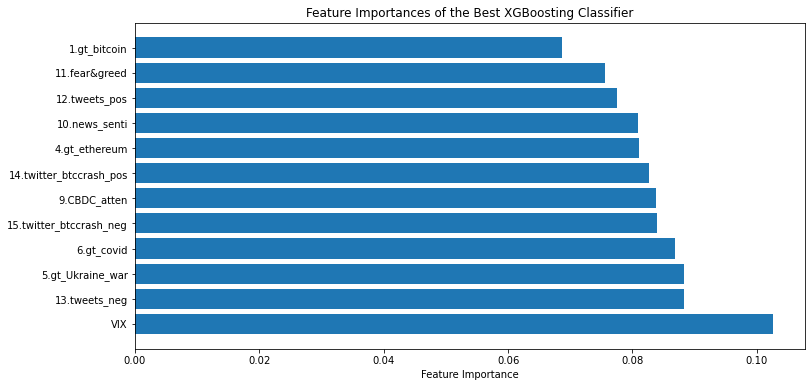

In [64]:
# Calculate feature importances
importances = best_xgb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best XGBoosting Classifier')
plt.show()

In [46]:
# Create a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.8, 1],
}

# Instantiate GridSearchCV with the Gradient Boosting classifier and the parameter grid
grid_search = GridSearchCV(gb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the Gradient Boosting classifier with the best parameters
best_gb_clf = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_gb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.5}
Accuracy:  0.5660377358490566
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.29      0.40       261
           1       0.55      0.83      0.66       269

    accuracy                           0.57       530
   macro avg       0.59      0.56      0.53       530
weighted avg       0.59      0.57      0.53       530



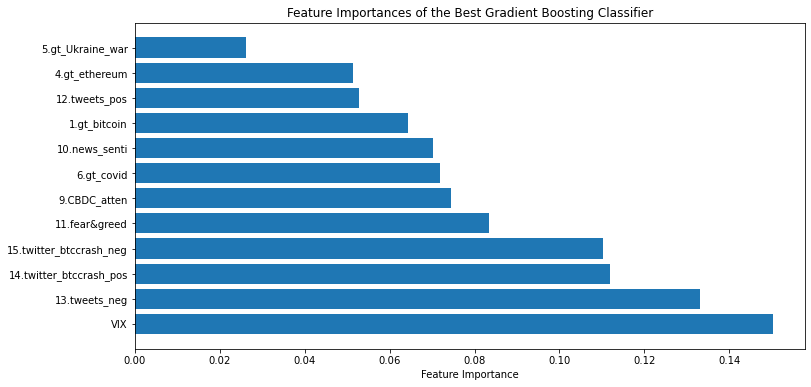

In [48]:
# Calculate feature importances
importances = best_gb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best Gradient Boosting Classifier')
plt.show()

# 2. Ether

In [65]:
ether_control = pd.concat([ether,df_control], axis=1)
train, test = train_test_split(ether_control, test_size = 0.3)
x_train = train.iloc[0:,1:13]
y_train = train.iloc[0:,0]
x_test = test.iloc[0:,1:13]
y_test = test.iloc[0:,0]

In [66]:
# Ignore the FutureWarning from the XGBoost library
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Instantiate GridSearchCV with the XGBoost classifier and the parameter grid
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_xgb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Accuracy:  0.5113207547169811
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.38      0.43       250
           1       0.53      0.62      0.57       280

    accuracy                           0.51       530
   macro avg       0.50      0.50      0.50       530
weighted avg       0.51      0.51      0.50       530



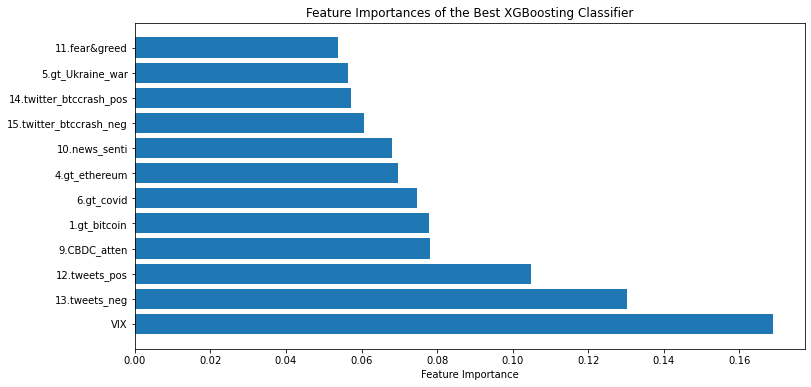

In [67]:
# Calculate feature importances
importances = best_xgb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best XGBoosting Classifier')
plt.show()

In [29]:
# Create a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.8, 1],
}

# Instantiate GridSearchCV with the Gradient Boosting classifier and the parameter grid
grid_search = GridSearchCV(gb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the Gradient Boosting classifier with the best parameters
best_gb_clf = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_gb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Accuracy:  0.5679245283018868
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       266
           1       0.55      0.73      0.63       264

    accuracy                           0.57       530
   macro avg       0.58      0.57      0.56       530
weighted avg       0.58      0.57      0.56       530



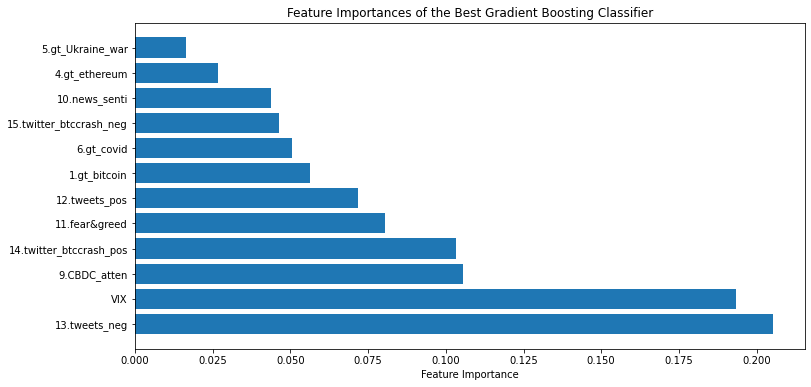

In [42]:
# Calculate feature importances
importances = best_gb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best Gradient Boosting Classifier')
plt.show()

# 3. BDM_exlarge

In [68]:
BDM_exlarge_control = pd.concat([BDM_exlarge,df_control], axis=1)
train, test = train_test_split(BDM_exlarge_control, test_size = 0.3)
x_train = train.iloc[0:,1:13]
y_train = train.iloc[0:,0]
x_test = test.iloc[0:,1:13]
y_test = test.iloc[0:,0]

In [69]:
# Ignore the FutureWarning from the XGBoost library
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Instantiate GridSearchCV with the XGBoost classifier and the parameter grid
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_xgb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Accuracy:  0.6132075471698113
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.46      0.51       229
           1       0.64      0.73      0.68       301

    accuracy                           0.61       530
   macro avg       0.60      0.60      0.59       530
weighted avg       0.61      0.61      0.61       530



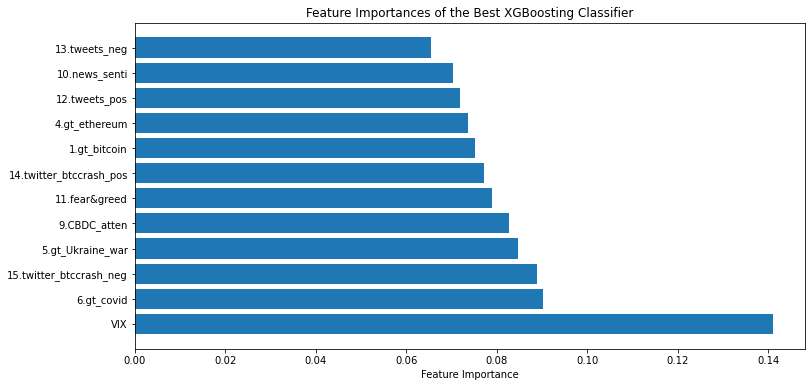

In [70]:
# Calculate feature importances
importances = best_xgb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best XGBoosting Classifier')
plt.show()

In [55]:
# Create a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.8, 1],
}

# Instantiate GridSearchCV with the Gradient Boosting classifier and the parameter grid
grid_search = GridSearchCV(gb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the Gradient Boosting classifier with the best parameters
best_gb_clf = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_gb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Accuracy:  0.6094339622641509
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.31      0.44       257
           1       0.58      0.89      0.70       273

    accuracy                           0.61       530
   macro avg       0.65      0.60      0.57       530
weighted avg       0.65      0.61      0.57       530



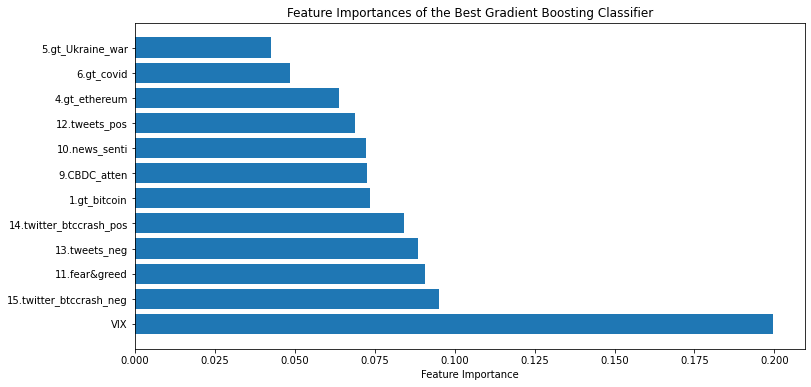

In [56]:
# Calculate feature importances
importances = best_gb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best Gradient Boosting Classifier')
plt.show()

# 4. BDM

In [71]:
BDM_control = pd.concat([BDM,df_control], axis=1)
train, test = train_test_split(BDM_control, test_size = 0.3)
x_train = train.iloc[0:,1:13]
y_train = train.iloc[0:,0]
x_test = test.iloc[0:,1:13]
y_test = test.iloc[0:,0]

In [72]:
# Ignore the FutureWarning from the XGBoost library
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Instantiate GridSearchCV with the XGBoost classifier and the parameter grid
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_xgb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Accuracy:  0.6056603773584905
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       248
           1       0.61      0.71      0.66       282

    accuracy                           0.61       530
   macro avg       0.60      0.60      0.60       530
weighted avg       0.60      0.61      0.60       530



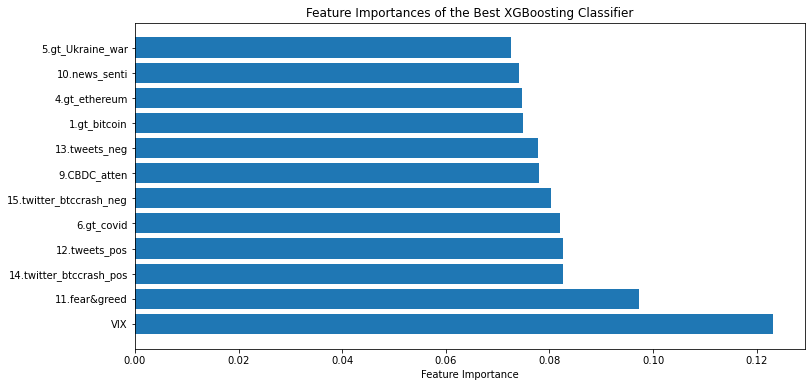

In [73]:
# Calculate feature importances
importances = best_xgb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best XGBoosting Classifier')
plt.show()

In [60]:
# Create a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.8, 1],
}

# Instantiate GridSearchCV with the Gradient Boosting classifier and the parameter grid
grid_search = GridSearchCV(gb_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the Gradient Boosting classifier with the best parameters
best_gb_clf = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gb_clf.fit(x_train, y_train)

# Predict the labels for the test set
y_pred = best_gb_clf.predict(x_test)

# Calculate and display the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Accuracy:  0.6132075471698113
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.37      0.47       248
           1       0.60      0.83      0.70       282

    accuracy                           0.61       530
   macro avg       0.63      0.60      0.58       530
weighted avg       0.62      0.61      0.59       530



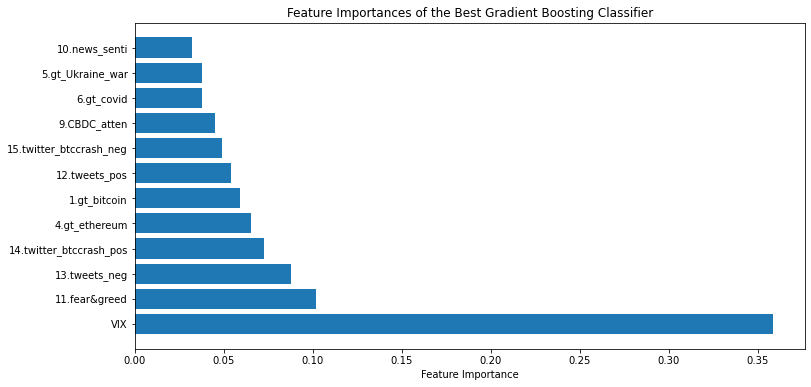

In [61]:
# Calculate feature importances
importances = best_gb_clf.feature_importances_

# Sort the feature importances and their corresponding indices
sorted_indices = np.argsort(importances)[::-1]

# Create a horizontal bar chart of the feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(x_train.shape[1]), importances[sorted_indices])
plt.yticks(range(x_train.shape[1]), np.array(feature_names)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Best Gradient Boosting Classifier')
plt.show()